In [1]:
#import paper_plots as carlosplt
from pymongo import MongoClient
import stat_tests as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import csv
from matplotlib.font_manager import FontProperties
import seaborn as sns
import laplace_tests as lptests
import statsmodels.api as sm
import datetime

In [2]:
class Plotter:
    def __init__(self, src2month, pkg_with_cvss, years):
        self.src2month = src2month
        self.pkg_with_cvss = pkg_with_cvss
        self.years = years
        self.src2month_temp = dict()
        self.src2month_loc = dict()
        self.l=self.m=self.h=self.udef=0

    def plot_severity_percentage(self):
        num_low = [0] * (self.years+1)
        num_med = [0] * (self.years+1)
        num_high = [0] * (self.years+1)
        num_udef = [0] * (self.years+1)
        total = [0] * (self.years+1)
        for i in self.pkg_with_cvss:
            for j in range(len(self.src2month[i])):
                try:
                    num_low[j//12] += self.pkg_with_cvss[i][j][0]
                    num_med[j//12] += self.pkg_with_cvss[i][j][1]
                    num_high[j//12] += self.pkg_with_cvss[i][j][2]
                    num_udef[j//12] += self.pkg_with_cvss[i][j][3]
                    total[j//12] += self.pkg_with_cvss[i][j][3] + self.pkg_with_cvss[i][j][2] + self.pkg_with_cvss[i][j][1] + self.pkg_with_cvss[i][j][0]
                except IndexError:
                    xx = j//12
                    if xx==19:
                        continue
                    else:
                        raise IndexError('List index out of bounds')
        ## Generate percentage
        for i in range(self.years + 1):
            try:
                num_low[i] = num_low[i]/total[i]
                num_med[i] = num_med[i]/total[i]
                num_high[i] = num_high[i]/total[i]
                num_udef[i] = num_udef[i]/total[i]
            except ZeroDivisionError:
                num_low[i] = 0
                num_med[i] = 0
                num_high[i] = 0
                num_udef[i] = 0

        print(num_low)
        print(num_high)


        #carlosplt.pre_paper_plot()        

        pal = ['#fee8c8', '#fdbb84', '#e34a33', 'grey']
        x = range(2001, 2001 + self.years)

        labels_cvss = ['low', 'medium', 'high', 'N/A']

        h = plt.stackplot(x, [num_low[1:], num_med[1:], num_high[1:], num_udef[1:]], colors = pal, alpha=0.9, labels = labels_cvss)
        plt.xticks(x)
        plt.legend(loc='upper left', handles = h[::-1])
        #carlosplt.post_paper_plot(True,True,True)
        plt.show()

    
    ## Plot sum of vulnerabilities. Can filter out by severity using the booleans low, med, high, undefined
    def plot_all_severity(self, l, m, h, udef):
        #carlosplt.pre_paper_plot()
        self.l = l
        self.m = m
        self.h = h
        self.udef = udef
        for i in self.pkg_with_cvss:
            self.src2month_temp[i]=[]
            for j in range(len(self.src2month[i])):
                num_low = self.pkg_with_cvss[i][j][0]
                num_med = self.pkg_with_cvss[i][j][1]
                num_high = self.pkg_with_cvss[i][j][2]
                num_udef = self.pkg_with_cvss[i][j][3]
                tempp = 0
                if l:
                    tempp += num_low
                if m:
                    tempp += num_med
                if h:
                    tempp += num_high
                if udef:
                    tempp += num_udef
                self.src2month_temp[i].append(tempp)

        for i in self.src2month:
            self.src2month_loc[i]=self.src2month_temp[i][:] # don't cut data for 2018

        self.severityPlotter = Temp_Plotter(self)
        self.severityPlotter.plot_total()

        # Plot total number per year
        self.pkgnumPlotter = NumPackages_Plotter(self.severityPlotter)
        
        # Plot number of affected packages per year
        self.pkgnumPlotter.plot_num_affected()
        
        # Plot average number of vulnerabilities per affected package per year
        self.pkgnumPlotter.plot_average_number()

        # Plot regular and LTS for Wheezy
        self.wheezy = WheezyPloter(self)
        self.wheezy.plot_wheezy_lts()

In [3]:
class Temp_Plotter:
    def __init__(self, plotter):
        self.src2month = plotter.src2month
        self.pkg_with_cvss = plotter.pkg_with_cvss
        self.years = plotter.years
        self.src2month_loc = plotter.src2month_loc

        self.src2sum = dict()
        self.src2year = dict()
        self.src2lastyears = dict()
        self.src2dens = dict()
        self.src2month_temp = dict()
        self.year_sum = []
        self.year_num = []

    def plot_total(self):
        self.year_sum = [0] * self.years
        self.year_num = [0] * self.years
        for pkg in self.src2month_loc:
            for j in range(self.years):
                temp =  sum(self.src2month_loc[pkg][12*(1+j):12*(2+j)])
                if (temp>0):
                    self.year_num[j] += 1
                self.year_sum[j] += temp 
            ## For last 2 years
            total = sum(self.src2month_loc[pkg][:])
            last_years = sum(self.src2month_loc[pkg][-24:])
            #print(pkg + '; ' + str(last_years))
            if (total>1):
                self.src2sum[pkg] = total
                self.src2lastyears[pkg] = last_years
        
        #calc total
        sum_total = 0
        one_only=0
        one_plus=0
        for p in self.src2month:
            sum_part = sum(self.src2month_loc[p][:])
            sum_total += sum_part
            if (sum_part == 1):
                one_only += 1
            elif (sum_part>1):
                one_plus += 1

        print('Total = ', sum_total)
        print('one_only = ', one_only)
        print('one_plus = ', one_plus)

        values = sorted(self.src2sum.values(),reverse=True)
        #print(values)
        keys = list(sorted(self.src2sum, key=self.src2sum.__getitem__, reverse=True))

        n = len(self.year_sum)
        yearsx = []
        for i in range(1,self.years+1):
            if i%2==1:
                yearsx.append('\''+str(i).zfill(2))
            else:
                yearsx.append('')
        x = range(self.years)

        width = 1/2
        plt.bar(x, self.year_sum, width, color='darkblue', edgecolor='black')
        #plt.bar(x, average_per_year, width)
        plt.xticks(np.arange(0,n),yearsx)
        plt.ylabel('Total vulnerabilities')
        plt.xlabel('Year')
        #carlosplt.post_paper_plot(True,True,True)
        
        sum_all = sum(values)
        print("Total: ", sum_all)

        ## Linear regression model
        X = sm.add_constant(x)
        y = self.year_sum
        model = sm.OLS(y,X).fit()
        predictions = model.predict(X)
        plt.plot(predictions)
        plt.show()
        print(model.summary())
        #print(model.summary().as_latex())

In [4]:
class NumPackages_Plotter:
    def __init__(self, plotter):
        self.plotter = plotter
        self.yearsx = []

    def plot_num_affected(self):
        ## Number of affected packages
        n = len(self.plotter.year_sum)
        for i in range(1,self.plotter.years+1):
            if i%2==1:
                self.yearsx.append('\''+str(i).zfill(2))
            else:
                self.yearsx.append('')
        x = range(self.plotter.years)
        width = 1/2
        plt.bar(x, self.plotter.year_num, width, color='darkblue', edgecolor='black')
        plt.xticks(np.arange(0,n),self.yearsx)
        plt.ylabel('Number of affected packages')
        plt.xlabel('Year')
        #carlosplt.post_paper_plot(True,True,True)
        plt.show()

    def plot_average_number(self):
        average_per_year = [0] * self.plotter.years
        for j in range(self.plotter.years):
            average_per_year[j] = self.plotter.year_sum[j]/float(self.plotter.year_num[j])
        
        x_values = list(range(1,self.plotter.years+1))
        slope = np.polyfit(x_values,average_per_year,1)
        
        print('Slope: ' + str(slope))
        
        n = len(self.plotter.year_sum)
        x = range(self.plotter.years)
        width = 1/2
        #plt.bar(x, year_sum, width)
        plt.bar(x, average_per_year, width, color='darkblue', edgecolor='black')
        plt.xticks(np.arange(0,n),self.yearsx)
        plt.ylabel('Average vulnerabilities per package')
        plt.xlabel('Year')
        #carlosplt.post_paper_plot(True,True,True)
        ## Linear regression
        X = sm.add_constant(x)
        y = average_per_year
        model = sm.OLS(y,X).fit()
        predictions = model.predict(X)
        plt.plot(predictions)
        plt.show()
        print(model.summary())
        #print(model.summary().as_latex())

In [5]:
class WheezyPloter:
    def __init__(self, plotter):
        self.plotter = plotter
        self.yearsx = []
        self.l = plotter.l
        self.m = plotter.m
        self.h = plotter.h
        self.udef = plotter.udef


    def plot_wheezy_lts(self):
        quarter_num = self.plotter.years*4
        # Get LTS and plot
        try:
            with open("DLA_sum.txt","rb") as fp:
                ltslist = pickle.load(fp)
            with open("src2month_DLA.txt","rb") as fp:
                src2monthDLAs = pickle.load(fp)
            with open("DLA_src2month.json","r") as fp:
                src2monthDLA = json.load(fp)
            with open("DLA_withcvss.json","r") as fp:
                self.src2monthDLA_cvss = json.load(fp)
                # Fix this so it can compute when required
                #dla.permonthDLA(src2monthDLAs)
            with open("1000.csv","r") as csvfile:
                spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

        except IOError:
            ltslist = dla.getDLAs()
            with open("src2month_DLA.txt","rb") as fp:
                src2monthDLAs = pickle.load(fp)
            dla.permonthDLA(src2monthDLAs)
            return self.plot_wheezy_lts()
        
        ## Plot for wheezy
        quarter_sum = [0] * quarter_num

        DLA_temp=dict()
        
        ## Fix src2monthDLA_cvss
        for i in self.src2monthDLA_cvss:
            temp_list = []
            for j in self.src2monthDLA_cvss[i]:
                temp_list += j
            self.src2monthDLA_cvss[i] = temp_list

        ## Fix ltslist according to severity
        for i in self.src2monthDLA_cvss:
            DLA_temp[i]=[]
            for j in range(len(self.src2monthDLA_cvss[i])):
                num_low = self.src2monthDLA_cvss[i][j][0]
                num_med = self.src2monthDLA_cvss[i][j][1]
                num_high = self.src2monthDLA_cvss[i][j][2]
                num_udef = self.src2monthDLA_cvss[i][j][3]
                tempp = 0
                if self.l:
                    tempp += num_low
                if self.m:
                    tempp += num_med
                if self.h:
                    tempp += num_high
                if self.udef:
                    tempp += num_udef
                DLA_temp[i].append(tempp)

        
        ltslist = []

        for m in range((self.plotter.years+1)*12):
            s = 0
            #print(m)
            for i in DLA_temp:
                s += DLA_temp[i][m]
            ltslist.append(s)


        totalLTS = ltslist
        plt.bar([i for i in range(len(ltslist))],ltslist)
        plt.show()

        quartersx = []
        for i in range(1,self.plotter.years+1):
            for j in range(1,5):
                if j==1:
                    quartersx.append('Q' + str(j)+'\''+str(i).zfill(2))
                else:
                    quartersx.append(' ')
    
        for pkg in self.plotter.src2month_loc:
            for j in range(quarter_num):
                temp =  sum(self.plotter.src2month_loc[pkg][12+(3*j):12+3*(j+1)])
                quarter_sum[j] += temp 

        LTS_quarter = []
    
        for j in range(quarter_num):
            temp = sum(totalLTS[12+(3*j):12+3*(j+1)])
            LTS_quarter.append(temp)

        ## Print all LTS
        cut = 12*4+1
        n = len(quarter_sum)
        x = range(quarter_num)
        width = 1/2

        plt.bar(x, LTS_quarter, width, color='brown', label='regular support', edgecolor='black')
    
        plt.xticks(np.arange(0,n),quartersx, rotation="vertical")
        plt.ylabel('Vulnerabilities per quarter of Debian LTS')
        plt.xlabel('Quarter')
        #carlosplt.post_paper_plot(True,True,True)
        plt.show()
    
        ## Filter only wheezy:
        quarter_sum_regular = [0] * (12*4+1) + quarter_sum[12*4+1:12*4+9] + [0] * 12
        quarter_sum_errors = [0] * (12*4 + 9) + quarter_sum[12*4+9:12*4+9+5] + [0] * 7
        LTS_quarter = [0] * (15*4+2) + LTS_quarter[15*4+2:-3]
        
        whole_w = quarter_sum_regular[:-12] + quarter_sum_errors[12*4+9:-7] + LTS_quarter[15*4+2:]
    
        #print(quarter_sum_errors)
        cut = 12*4+1
        n = len(quarter_sum) - cut
        x = range(quarter_num-cut-3)
        width = 1/2
        
        #print(len(LTS_quarter))
        print(len(x))
        print(len(quarter_sum_regular[cut:]))
        print(len(quarter_sum_errors[cut:]))
        bar1 = plt.bar(x, quarter_sum_regular[cut:], width, color='darkblue', label='regular', edgecolor='black')
        bar12 = plt.bar(x, quarter_sum_errors[cut:], width, color='darkorange', label='regular*', edgecolor='black')
        bar2 = plt.bar(x, LTS_quarter[cut:], width, color='darkred', label ='long-term', edgecolor='black')
        plt.legend(handles=[bar1, bar12, bar2])
    
        plt.xticks(np.arange(0,n),quartersx[cut:], rotation="vertical")
        plt.ylabel('Vulnerabilities per quarter')
        plt.xlabel('Quarter')
        #carlosplt.post_paper_plot(True,True,True)
        ## Linear Regression
        print(len(x))
        print(len(whole_w[cut:]))
        X = sm.add_constant(x)
        y = whole_w[cut:]
        model = sm.OLS(y,X).fit()
        predictions = model.predict(X)
        plt.plot(predictions)
        plt.show()
        print(model.summary())
        #print(model.summary().as_latex())

In [6]:
def plot_all(all_once, pkg_with_cvss):
    years = 18
    # 2001-2000+years

    myplotter = Plotter(src2month, pkg_with_cvss, years)
    
    # consider severity (low, medium, high, undefined)
    # Undefined is usual for newly added packages
    myplotter.plot_all_severity(True,True,True,True)
    myplotter.plot_severity_percentage()

In [7]:
with open('./vendors/debian/cache/src2dsa') as fp:
    src2dsa=json.load(fp)
with open('./vendors/debian/cache/dsa2cve') as fp:
    dsa2cve=json.load(fp)
with open('./vendors/debian/cache/src2month') as fp:
    src2month=json.load(fp)
with open('./vendors/debian/cache/pkg_with_cvss') as fp:
    pkg_with_cvss=json.load(fp)
with open('./vendors/debian/cache/dsainfo') as fp:
    dsainfo=json.load(fp)

client = MongoClient('mongodb://localhost:27017/')
db = client.cvedb

# Get the collection object
# Here name of the database is "states"

collection  = db.cves

# Make a query to list all the documents

cvedicttemp=collection.find()

In [8]:
cvedict=dict()
for key in cvedicttemp:
    cvedict[key['id']]=key

In [9]:
single_src2month=dict()
single_pkg_with_cvss=dict()

In [10]:
# Number counted once
cve_once=dict()
repeat_count=dict()
for dsa in dsa2cve:
    for cve in dsa2cve[dsa]:
        if cve not in cve_once:
            date1=dsainfo[dsa][1]
            date1 = datetime.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
            try:
                date2=cvedict[cve]['Published']
                if date1<date2:
                    date=date1
                else:
                    date=date2
                cve_once[cve]=date
                repeat_count[cve]=[date1]
                continue
            except KeyError:
                continue
        if cve in cve_once:
            date1=dsainfo[dsa][1]
            date1 = datetime.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
            date2=cve_once[cve]
            if date1<date2:
                date=date1
            else:
                date=date2    
            cve_once[cve]=date
            repeat_count[cve].append(date1)

In [11]:
num_once = 12*20*[0]
for cve in cve_once:
    date=cve_once[cve]
    num_once[(date.year-2000)*12+date.month-1]+=1

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 4, 12, 17, 5, 9, 6, 4, 4, 5, 5, 6, 7, 7, 12, 3, 1, 10, 7, 28, 17, 21, 21, 30, 26, 8, 34, 16, 13, 36, 26, 22, 26, 6, 9, 13, 23, 23, 19, 25, 12, 19, 14, 26, 17, 20, 20, 45, 58, 27, 18, 28, 40, 21, 51, 60, 56, 64, 55, 73, 26, 36, 34, 69, 43, 42, 41, 43, 37, 19, 26, 33, 13, 22, 49, 43, 40, 59, 47, 25, 45, 38, 45, 35, 38, 50, 46, 36, 31, 28, 40, 30, 46, 32, 36, 43, 37, 34, 67, 66, 33, 49, 44, 34, 53, 47, 41, 44, 34, 49, 16, 27, 21, 44, 39, 42, 35, 31, 41, 37, 60, 47, 80, 40, 65, 35, 41, 46, 35, 47, 27, 28, 69, 48, 45, 35, 41, 59, 42, 48, 24, 40, 37, 19, 27, 41, 60, 47, 76, 87, 61, 46, 45, 65, 67, 66, 53, 64, 68, 87, 43, 38, 65, 56, 39, 93, 60, 76, 68, 57, 59, 90, 66, 55, 90, 69, 56, 86, 69, 72, 115, 99, 115, 91, 99, 86, 112, 111, 104, 42, 64, 103, 169, 73, 106, 113, 68, 86, 146, 141, 198, 106, 95, 106, 117, 67, 93, 161, 56, 77, 93, 42, 57, 54, 51, 80, 42, 85, 65, 36, 36, 67, 53, 46, 40, 20, 0, 2]
[96, 164, 235, 263, 551, 449, 461, 456, 549, 416, 551,

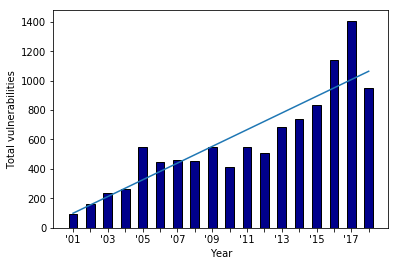

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     64.72
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           5.16e-07
Time:                        15:39:36   Log-Likelihood:                -115.30
No. Observations:                  18   AIC:                             234.6
Df Residuals:                      16   BIC:                             236.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.7544     70.251      1.406      0.1

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [12]:
# Plot total number
years=18
year_sum=20*[0]
for i in range(len(num_once)):
    year_sum[i//12]+=num_once[i]
year_sum=year_sum[1:-1]
print(num_once)
print(year_sum)
n = len(year_sum)
print(n)
yearsx = []
for i in range(1,years+1):
    if i%2==1:
        yearsx.append('\''+str(i).zfill(2))
    else:
        yearsx.append('')

x = range(years)
width = 1/2
plt.bar(x, year_sum, width, color='darkblue', edgecolor='black')
#plt.bar(x, average_per_year, width)
plt.xticks(np.arange(0,n),yearsx)
plt.ylabel('Total vulnerabilities')
plt.xlabel('Year')
#carlosplt.post_paper_plot(True,True,True)

## Linear regression model
X = sm.add_constant(x)
y = year_sum
model = sm.OLS(y,X).fit()
predictions = model.predict(X)
plt.plot(predictions)
plt.show()
print(model.summary())
#print(model.summary().as_latex())

In [13]:
repeatsdict=dict()
for cve in repeat_count:
    if len(repeat_count[cve])>1:
        cve_id=cve
        sources=[]
        dsas=[]
        repeats=len(repeat_count[cve])-1
        for dsa in dsa2cve:
            if cve in dsa2cve[dsa]:
                dsas.append(dsa)
                for src in src2dsa:
                    if int(dsa) in src2dsa[src]:
                        if src in sources:
                            continue
                        else:
                            sources.append(src)
        repeatsdict[cve_id]=(repeats, dsas, sources)

In [14]:
sources2repeats=dict()
repeat_year=20*[0]
for cve in repeatsdict:
    if len(repeatsdict[cve][2])>1:
        date=cve_once[cve]
        print(repeatsdict[cve], date.year)
        repeat_year[date.year-2000]+=len(repeatsdict[cve][2])
        if str(set(repeatsdict[cve][2])) in sources2repeats:
            sources2repeats[str(set(repeatsdict[cve][2]))]+=1
        else:
            sources2repeats[str(set(repeatsdict[cve][2]))]=1

(2, ['23', '27', '86'], ['inn2', 'openssh']) 2001
(1, ['64', '81'], ['w3m', 'w3m-ssl']) 2001
(1, ['69', '695'], ['xloadimage', 'xli']) 2001
(1, ['70', '75'], ['netkit-telnet', 'netkit-telnet-ssl']) 2001
(1, ['90', '121'], ['xtel', 'xtell']) 2001
(4, ['142', '143', '146', '149', '333'], ['openafs', 'krb5', 'dietlibc', 'glibc', 'acm']) 2002
(2, ['176', '179', '182'], ['gv', 'gnome-gv', 'kdegraphics']) 2002
(2, ['183', '184', '185'], ['krb5', 'heimdal']) 2002
(2, ['222', '226', '232'], ['xpdf', 'cups']) 2003
(9, ['234', '235', '236', '237', '238', '239', '240', '241', '242', '243'], ['kdeadmin', 'kdegraphics', 'kdelibs', 'kdenetwork', 'kdepim', 'kdesdk', 'kdegames', 'kdeutils', 'kdebase', 'kdemultimedia']) 2003
(2, ['249', '250', '251'], ['w3mmee', 'w3mmee-ssl', 'w3m', 'w3m-ssl']) 2002
(2, ['249', '250', '251'], ['w3mmee', 'w3mmee-ssl', 'w3m', 'w3m-ssl']) 2003
(2, ['266', '272', '282'], ['krb5', 'dietlibc', 'glibc']) 2003
(2, ['266', '269', '273'], ['krb5', 'heimdal']) 2003
(1, ['267', '2

In [15]:
sorted_x = sorted(sources2repeats.items(), key=lambda kv: kv[1], reverse=True)

In [21]:
total=0
for i in sorted_x:
    print(i)
    total+=i[1]

("{'firefox-esr', 'icedove'}", 371)
("{'iceape', 'firefox-esr', 'icedove'}", 87)
("{'mysql-transitional', 'mariadb-10.1'}", 85)
("{'iceape', 'firefox-esr', 'icedove', 'xulrunner'}", 57)
("{'iceape', 'firefox-esr', 'xulrunner'}", 28)
("{'firefox-esr', 'icedove', 'graphite2'}", 23)
("{'icedove', 'xulrunner'}", 16)
("{'kdegraphics', 'xpdf'}", 15)
("{'php7', 'file'}", 13)
("{'graphicsmagick', 'imagemagick'}", 11)
("{'libsdl2-image', 'sdl-image1.2'}", 10)
("{'qemu', 'linux'}", 8)
("{'kazehakase', 'pcre3'}", 7)
("{'ruby2.3', 'jruby'}", 7)
("{'pdfkit', 'libextractor', 'koffice', 'xpdf', 'tetex-bin', 'gpdf', 'cups', 'pdftohtml'}", 6)
("{'xen', 'qemu'}", 6)
("{'firefox-esr', 'xulrunner'}", 6)
("{'openjdk', 'icu'}", 6)
("{'gtk+2.0', 'gdk-pixbuf'}", 5)
("{'xloadimage', 'xli'}", 4)
("{'egroupware', 'php7'}", 4)
("{'libphp-adodb', 'moodle', 'cacti'}", 4)
("{'mysql', 'mysql-dfsg', 'mysql-dfsg-4.1'}", 4)
("{'nss', 'firefox-esr', 'icedove'}", 4)
("{'openjpeg2', 'chromium-browser'}", 4)
("{'intel-micro

In [19]:
print(len(sorted_x))
print(total)

196


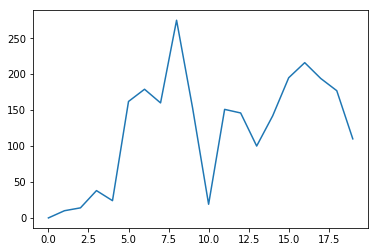

In [17]:
plt.plot(repeat_year)

Total =  12820
one_only =  605
one_plus =  695
Total:  12215


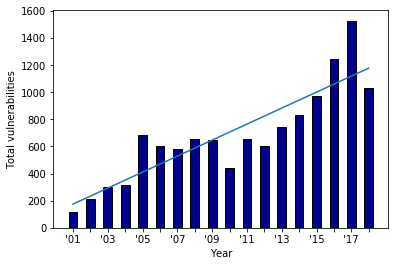

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     54.72
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           1.51e-06
Time:                        15:39:40   Log-Likelihood:                -117.51
No. Observations:                  18   AIC:                             239.0
Df Residuals:                      16   BIC:                             240.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.9766     79.435      2.203      0.0

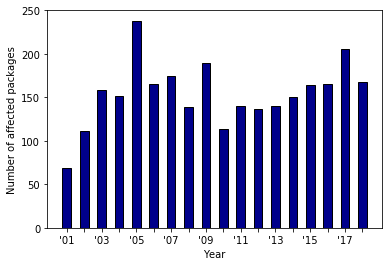

Slope: [0.32790091 1.13789389]


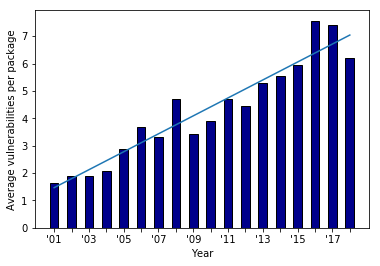

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     158.8
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           1.01e-09
Time:                        15:39:40   Log-Likelihood:                -14.448
No. Observations:                  18   AIC:                             32.90
Df Residuals:                      16   BIC:                             34.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4658      0.259      5.657      0.0

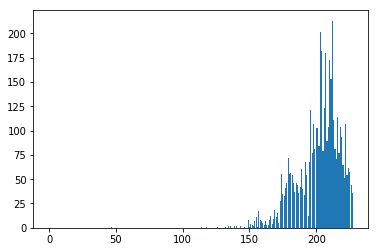

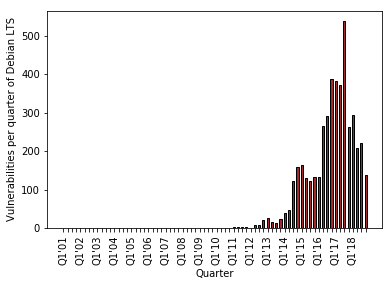

20
20
20
20
20


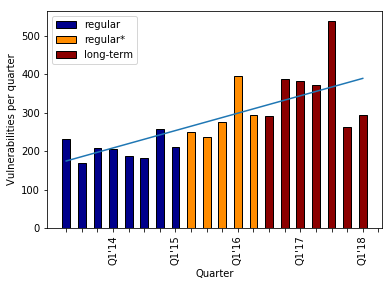

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     19.59
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           0.000326
Time:                        15:39:42   Log-Likelihood:                -111.10
No. Observations:                  20   AIC:                             226.2
Df Residuals:                      18   BIC:                             228.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.5571     28.413      6.144      0.0

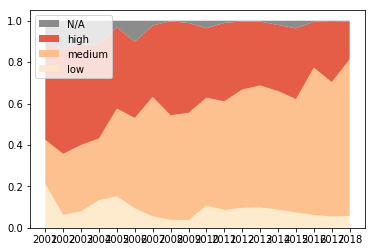

In [18]:
plot_all(src2month, pkg_with_cvss)